In [3]:
import pandas as pd 
import numpy as np
from pandas_datareader import data as pdr
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt

In [4]:
series = ['GDPC1','INDPRO','UNRATE','CPIAUCSL','RSXFS','FEDFUNDS','UMCSENT']
pieces = []
for s in series:
    s_df = pdr.DataReader(s, 'fred', start='1990-01-01')
    s_df = s_df.rename(columns={s: s})  
    pieces.append(s_df)

raw = pd.concat(pieces, axis=1)  

gdp = raw['GDPC1'].dropna().copy()
gdp.index = gdp.index.to_period('Q').to_timestamp('Q')  # 映射到季度末

# 3) 月度指标 -> 季度末：取季度均值（先向前填充可减少缺失）
monthly_cols = [c for c in raw.columns if c != 'GDPC1']
monthly_q = (raw[monthly_cols]
             .ffill()                   # 月度先向前填充，避免起始缺值导致整季为空
             .resample('Q').mean())     # 聚合到季度末

# 4) 合并并构造目标变量
data = pd.concat([gdp.rename('GDPC1'), monthly_q], axis=1)

# 仅以 GDP 存在为准保留样本；预测因子再做一次向前填充
data = data.sort_index()
df_features = data.drop(columns=['GDPC1']).ffill()
data = pd.concat([data['GDPC1'], df_features], axis=1).dropna(subset=['GDPC1'])

# 5) 计算季度GDP增速（%）
data['GDP_GROWTH'] = data['GDPC1'].pct_change()*100
data = data.dropna(subset=['GDP_GROWTH'])

data

/var/folders/gb/55xsbypx1kg72fy8c569_cpw0000gn/T/ipykernel_51633/3280056034.py:17: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  .resample('Q').mean())     # 聚合到季度末


,GDPC1,INDPRO,UNRATE,CPIAUCSL,RSXFS,FEDFUNDS,UMCSENT,GDP_GROWTH
DATE,,,,,,,,
1990-06-30,10083.855,62.544767,5.333333,129.300000,NaN,8.243333,90.933333,0.362970
1990-09-30,10090.569,62.799267,5.700000,131.533333,NaN,8.160000,79.133333,0.066582
1990-12-31,9998.704,61.834433,6.133333,133.766667,NaN,7.743333,65.133333,-0.910405
1991-03-31,9951.916,60.673400,6.600000,134.766667,NaN,6.426667,74.966667,-0.467941
1991-06-30,10029.510,61.020833,6.833333,135.566667,NaN,5.863333,80.733333,0.779689
...,...,...,...,...,...,...,...,...
2024-06-30,23286.508,102.863300,4.000000,313.095667,598675.666667,5.330000,71.500000,0.885486
2024-09-30,23478.570,102.711400,4.166667,314.182667,606078.000000,5.263333,68.200000,0.824778
2024-12-31,23586.542,102.402933,4.133333,316.538667,617266.333333,4.650000,72.100000,0.459875


In [ ]:
features = data.drop(columns=["GDPC1", "GDP_GROWTH"]).copy()

features = features.loc[:, features.notna().any()]
vary = features.var(numeric_only=True)
features = features.loc[:, vary > 1e-8]

features = features.ffill()
features = features.replace([np.inf, -np.inf], np.nan)
features = features.dropna()

y = data["GDP_GROWTH"].reindex(features.index).dropna()
features = features.loc[y.index]

X = features.astype("float32").copy()
y = y.astype("float32").copy()

split = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split],  X.iloc[split:]
y_train, y_test = y.iloc[:split],  y.iloc[split:]

/Users/mac/anaconda3/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/var/folders/gb/55xsbypx1kg72fy8c569_cpw0000gn/T/ipykernel_51633/2768850699.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ar_pred_te = float(ar.predict(start=te_date, end=te_date)[0])
/Users/mac/anaconda3/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/var/folders/gb/55xsbypx1kg72fy8c569_cpw0000gn/T/ipykernel_51633/2768850699.py:183: Fu

{'RNN_RMSE': 2.230676579542171, 'RNN_MAE': 0.821530882308336, 'RNN_R2': -0.9557030339060419, 'AR_RMSE': 2.2209673891766277, 'AR_MAE': 0.802733780704861, 'AR_R2': -0.9409345641851123}


/var/folders/gb/55xsbypx1kg72fy8c569_cpw0000gn/T/ipykernel_51633/2768850699.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ar_pred_te = float(ar.predict(start=te_date, end=te_date)[0])


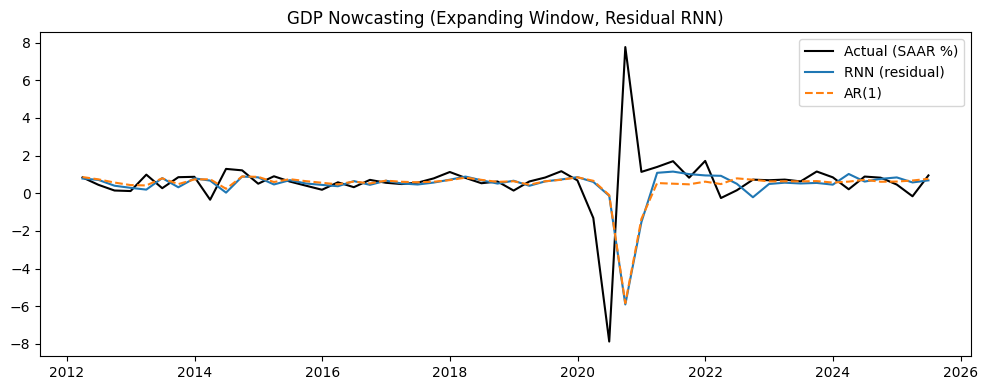

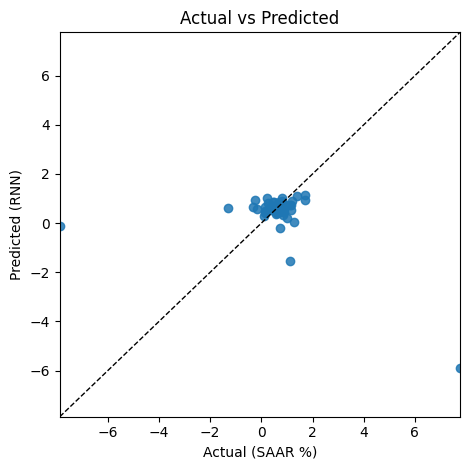

In [9]:
# ====================== RNN Residual Nowcasting: Expanding-Window ======================
# Requirements: X (DataFrame, index=quarter-end timestamps), y (Series, same index; e.g., SAAR log growth)
# Output: metrics (RMSE/MAE/R2), plots, and vectors of predictions

# ---- 0) Environment & imports ----
import os, random, numpy as np, pandas as pd
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

import torch
import torch.nn as nn
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt

device = torch.device("cpu")
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
set_seed(42)

# ---- 1) Helpers ----
def make_sequences(X_df: pd.DataFrame, y_sr: pd.Series, seq_len=6, end_index=None):
    """
    Build one-step-ahead sequences up to (and including) 'end_index' (for training),
    or exactly ending at 'end_index' (for test point).
    If end_index is None: build sequences over full overlap.
    Returns X_seq [N,L,F], y_seq [N], idx_seq [N]
    """
    X_df = X_df.copy(); y_sr = y_sr.copy()
    y_sr = y_sr.reindex(X_df.index).dropna()
    X_df = X_df.loc[y_sr.index]
    if end_index is not None:
        # restrict to <= end_index
        X_df = X_df.loc[X_df.index <= end_index]
        y_sr = y_sr.loc[y_sr.index <= end_index]
    Xv = X_df.values.astype(np.float32); yv = y_sr.values.astype(np.float32)
    idx = X_df.index

    X_seq, y_seq, t_idx = [], [], []
    for t in range(seq_len-1, len(Xv)):
        X_seq.append(Xv[t-seq_len+1:t+1, :])  # window ends at idx[t]
        y_seq.append(yv[t])                   # predict y_t
        t_idx.append(idx[t])
    if len(X_seq)==0:
        return None, None, None
    return np.stack(X_seq), np.asarray(y_seq), np.array(t_idx)

class RNNReg(nn.Module):
    def __init__(self, input_dim, hidden=64, rnn="gru", num_layers=2, dropout=0.2):
        super().__init__()
        if rnn.lower()=="lstm":
            self.rnn = nn.LSTM(input_dim, hidden, num_layers=num_layers, batch_first=True,
                               dropout=0.0 if num_layers==1 else dropout)
        else:
            self.rnn = nn.GRU(input_dim, hidden, num_layers=num_layers, batch_first=True,
                              dropout=0.0 if num_layers==1 else dropout)
        self.head = nn.Sequential(
            nn.Linear(hidden, 32), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        out,_ = self.rnn(x)       # [B,L,H]
        h = out[:, -1, :]         # last step
        return self.head(h)

def metrics(y_true, y_hat):
    y_true = np.asarray(y_true); y_hat = np.asarray(y_hat)
    rmse = float(np.sqrt(np.mean((y_true - y_hat)**2)))
    mae  = float(np.mean(np.abs(y_true - y_hat)))
    r2   = float(1 - np.var(y_true - y_hat)/np.var(y_true))
    return rmse, mae, r2

# ---- 2) Expanding-window residual-learning backtest ----
def expanding_rnn_residual_backtest(X, y,
                                    seq_len=6,
                                    start_min=80,       # 至少用多少个季度起步（根据你的样本量调整）
                                    rnn_type="gru",
                                    hidden=64, layers=2, dropout=0.2,
                                    lr=1e-3, weight_decay=1e-4,
                                    epochs=400, patience=30, batch=32):
    """
    每期：
      1) 用截止到 t-1 的数据拟合 AR(1)
      2) 构造训练序列（窗口长度 L），目标= y - AR(1) 预测（残差）
      3) 训练 RNN 预测残差；对 t 期做一次 out-of-sample 预测
      4) 最终预测 = AR(1) 预测 + RNN 残差预测
    """
    idx_all = list(X.index)
    preds_rnn, preds_ar, truth, dates = [], [], [], []

    for t in range(start_min, len(X)):  # predict index idx_all[t]
        te_date = idx_all[t]
        tr_end_date = idx_all[t-1]

        # --- Training data up to t-1 ---
        X_tr = X.loc[:tr_end_date]
        y_tr = y.loc[:tr_end_date]

        # --- Fit AR(1) on training target ---
        ar = AutoReg(y_tr, lags=1, old_names=False).fit()

        # --- Build training sequences up to t-1 ---
        seq_tr = make_sequences(X_tr, y_tr, seq_len=seq_len, end_index=tr_end_date)
        if seq_tr[0] is None:
            continue
        Xtr_seq, ytr_seq, tr_idx_seq = seq_tr

        # AR(1) predictions aligned to training sequence indices
        ar_pred_tr = pd.Series(ar.predict(start=tr_idx_seq[0], end=tr_idx_seq[-1]),
                               index=tr_idx_seq).astype('float32').values

        # Residual target for RNN
        y_res_tr = (ytr_seq - ar_pred_tr).astype(np.float32)

        # Standardize X (global across seq dims) and residual y
        X_mean = Xtr_seq.mean(axis=(0,1), keepdims=True); X_std = Xtr_seq.std(axis=(0,1), keepdims=True) + 1e-8
        y_mean = y_res_tr.mean(); y_std = y_res_tr.std() + 1e-8
        def zX(a): return (a - X_mean)/X_std
        def zy(a): return (a - y_mean)/y_std
        def invy(a): return a*y_std + y_mean

        Xtr_n = zX(Xtr_seq); ytr_n = zy(y_res_tr)

        # Split a small tail as validation for early stopping
        vcut = max(int(0.9*len(Xtr_n)), len(Xtr_n)-1)
        X_tr_n, y_tr_n = Xtr_n[:vcut], ytr_n[:vcut]
        X_val_n, y_val_n = Xtr_n[vcut:], ytr_n[vcut:]
        X_tr_t = torch.tensor(X_tr_n, dtype=torch.float32)
        y_tr_t = torch.tensor(y_tr_n, dtype=torch.float32).view(-1,1)
        X_val_t = torch.tensor(X_val_n, dtype=torch.float32)
        y_val_t = torch.tensor(y_val_n, dtype=torch.float32).view(-1,1)

        # --- Define and train RNN ---
        model = RNNReg(input_dim=X.shape[1], hidden=hidden, rnn=rnn_type,
                       num_layers=layers, dropout=dropout).to(device)
        opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=8, verbose=False)
        loss_fn = nn.SmoothL1Loss()

        best_val = np.inf; best_state = None; wait=0
        def batches(Xb, yb, bs):
            N = len(Xb); idx = np.arange(N); np.random.shuffle(idx)
            for i in range(0, N, bs):
                j = idx[i:i+bs]; yield Xb[j], yb[j]

        for ep in range(1, epochs+1):
            model.train(); train_loss=0.0
            for xb, yb in batches(X_tr_t, y_tr_t, batch):
                opt.zero_grad()
                pred = model(xb)
                loss = loss_fn(pred, yb)
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                opt.step()
                train_loss += loss.item()*len(xb)
            train_loss /= max(len(X_tr_t),1)

            model.eval()
            with torch.no_grad():
                val_pred = model(X_val_t) if len(X_val_t)>0 else torch.tensor([[0.0]])
                val_loss = loss_fn(val_pred, y_val_t).item() if len(X_val_t)>0 else train_loss

            sched.step(val_loss)
            if val_loss < best_val - 1e-5:
                best_val = val_loss; best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}
                wait = 0
            else:
                wait += 1
                if wait >= patience: break

        if best_state is not None:
            model.load_state_dict(best_state)

        # --- Build single test sequence ending at te_date ---
        X_te_one, y_te_one, te_idx = make_sequences(X.loc[:te_date], y.loc[:te_date],
                                                    seq_len=seq_len, end_index=te_date)
        # 只取最后一个（就是 te_date）
        X_te_one = X_te_one[[-1]]; y_te_one = y_te_one[[-1]]; te_idx = te_idx[[-1]]
        # 标准化同训练统计量
        X_te_n = (X_te_one - X_mean)/X_std
        X_te_t = torch.tensor(X_te_n, dtype=torch.float32)

        # AR(1) on test date
        ar_pred_te = float(ar.predict(start=te_date, end=te_date)[0])

        # RNN residual pred
        model.eval()
        with torch.no_grad():
            res_std = float(model(X_te_t).cpu().numpy().ravel()[0])
        res = float(invy(res_std))

        y_hat = ar_pred_te + res

        # collect
        preds_rnn.append(y_hat)
        preds_ar.append(ar_pred_te)
        truth.append(float(y_te_one[0]))
        dates.append(pd.Timestamp(te_idx[0]))

    # metrics
    rmse_rnn, mae_rnn, r2_rnn = metrics(truth, preds_rnn)
    rmse_ar , mae_ar , r2_ar  = metrics(truth, preds_ar)

    results = {
        "index": pd.Index(dates),
        "y_true": np.array(truth),
        "y_rnn": np.array(preds_rnn),
        "y_ar":  np.array(preds_ar),
        "metrics": {
            "RNN_RMSE": rmse_rnn, "RNN_MAE": mae_rnn, "RNN_R2": r2_rnn,
            "AR_RMSE": rmse_ar,   "AR_MAE": mae_ar,   "AR_R2": r2_ar
        }
    }
    return results

# ---- 3) Run backtest (use your X, y) ----
# 建议：seq_len=6 或 8；start_min 设为 >= 80（约20年数据起步）以保证序列足够训练
res = expanding_rnn_residual_backtest(
    X, y,
    seq_len=6, start_min=80,
    rnn_type="gru", hidden=64, layers=2, dropout=0.2,
    lr=1e-3, weight_decay=1e-4, epochs=400, patience=30, batch=16
)
print(res["metrics"])

# ---- 4) Plots ----
ti = res["index"]; yt = res["y_true"]; yr = res["y_rnn"]; ya = res["y_ar"]

plt.figure(figsize=(10,4))
plt.plot(ti, yt, color='k', label='Actual (SAAR %)')
plt.plot(ti, yr, label='RNN (residual)')
plt.plot(ti, ya, '--', label='AR(1)')
plt.title('GDP Nowcasting (Expanding Window, Residual RNN)')
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(4.8,4.8))
plt.scatter(yt, yr, alpha=0.85)
lims = [min(min(yt), min(yr)), max(max(yt), max(yr))]
plt.plot(lims, lims, 'k--', linewidth=1); plt.xlim(lims); plt.ylim(lims)
plt.xlabel('Actual (SAAR %)'); plt.ylabel('Predicted (RNN)')
plt.title('Actual vs Predicted'); plt.tight_layout(); plt.show()
